# Decison Tree - QRT ENS Data Challenge


## Libraries

In [9]:
#Libraries to import
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

## Loading data


In [10]:
#These in which we carried out feature engineering.
X_train = pd.read_csv('x_train.csv')
X_test = pd.read_csv('x_test.csv')
y_train = pd.read_csv('y_train.csv')

## Decision Tree and train score

In [14]:
#Defining the target df as just the 'TARGET' column
y_train_clean = y_train['TARGET']

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train_clean)

# Predict on the training set using the trained Random Forest model
predictions_rf = rf_model.predict(X_train)

# Define the metric function as Spear Correlation
def metric_train(output):
    return spearmanr(output, y_train_clean).correlation

# Calculate and print the Spearman correlation for the train set
correlation_rf = metric_train(predictions_rf)
print('Spearman correlation for the train set using Random Forest: {:.1f}%'.format(100 * correlation_rf))

Spearman correlation for the train set using Random Forest: 88.6%


Prediction to submit and test

In [15]:
#Creating the submission file with the prediction on X_test
y_test_submission = X_test[['ID']].copy()
predictions_test_rf = rf_model.predict(X_test)
y_test_submission['TARGET'] = rf_model.predict(X_test)
y_test_submission.to_csv('RandomForest.csv', index=False)

After submitting this DecisionTree.csv file, we obtain a public score of around 0.1781%. In the next step, we will try to improve the score by tuning hyperparameters.

But First, we will use this model to calculate the MAE and MSE.

#MAE and MSE

In [36]:
# Calculate MAE
mae = mean_absolute_error(y_train['TARGET'], predictions_rf)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate MSE
mse = mean_squared_error(y_train['TARGET'], predictions_rf)
print(f'Mean Squared Error (MSE): {mse}')


Mean Absolute Error (MAE): 0.23921756541959313
Mean Squared Error (MSE): 0.16393199047269372


## Hyperparameter Tuning

In [16]:
# Define the custom scoring function using Spearman correlation
def custom_spearman_scorer(estimator, X, y):
    predictions = estimator.predict(X)
    spearman_corr, _ = spearmanr(predictions, y)
    return spearman_corr

In [19]:
# Hyperparameter optimization using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           scoring=custom_spearman_scorer,
                           cv=None,
                           n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train_clean)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

# Use the best model from grid search for predictions
best_rf_model = grid_search.best_estimator_
y_pred_best = best_rf_model.predict(X_test)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}


In [21]:
#Create file for submission having used the best hyperparameters.
y_test_submission['TARGET'] = best_rf_model.predict(X_test)
y_test_submission.to_csv('RandomForest_best_eng.csv', index=False)

#Feature Importance

In [27]:
# Calculate permutation feature importances
result = permutation_importance(best_rf_model, X_test, y_pred_best, n_repeats=30, random_state=42)

# Get feature names and their importance scores
feature_names = X_test.columns
permutation_importances = result.importances_mean

# Create a dictionary mapping feature names to importance scores
permutation_importance_dict = dict(zip(feature_names, permutation_importances))

# Print or use the permutation importance dictionary as needed
print("Permutation Feature Importance:")
for feature, importance in permutation_importance_dict.items():
    print(f"{feature}: {importance}")

Permutation Feature Importance:
ID: 0.25148844669976544
DE_CONSUMPTION: 0.021576441651041372
FR_CONSUMPTION: 0.04068617800749432
DE_NET_IMPORT: 0.12842299251058495
FR_NET_IMPORT: 0.011069056573898653
DE_GAS: 0.02250769535979832
FR_GAS: 0.04192836171841994
DE_COAL: 0.013728215580161058
FR_COAL: 0.008610495550985024
DE_HYDRO: 0.02589514824769967
FR_HYDRO: 0.01701543679821442
DE_NUCLEAR: 0.011473926645698481
FR_NUCLEAR: 0.005999768904709916
DE_SOLAR: 0.06972294742802833
FR_SOLAR: 0.018104341168485884
DE_WINDPOW: 0.29189568059166004
FR_WINDPOW: 0.0260104372697116
DE_LIGNITE: 0.08974470745936869
DE_RESIDUAL_LOAD: 0.13134271045034782
FR_RESIDUAL_LOAD: 0.03106843447460002
DE_RAIN: 0.032048794148386385
FR_RAIN: 0.006202393152598784
DE_WIND_SQCB: 0.28361253337347336
FR_WIND_SQCB: 0.01728442443768043
DE_TEMP: 0.012764535886656946
FR_TEMP: 0.015536310052188062
GAS_RET: 0.1671602124235698
COAL_RET: 0.009169300771682225
CARBON_RET: 0.03752078163623686
DE_WIND_EXCESS: 0.03367541430864081
FR_WIND_EXC

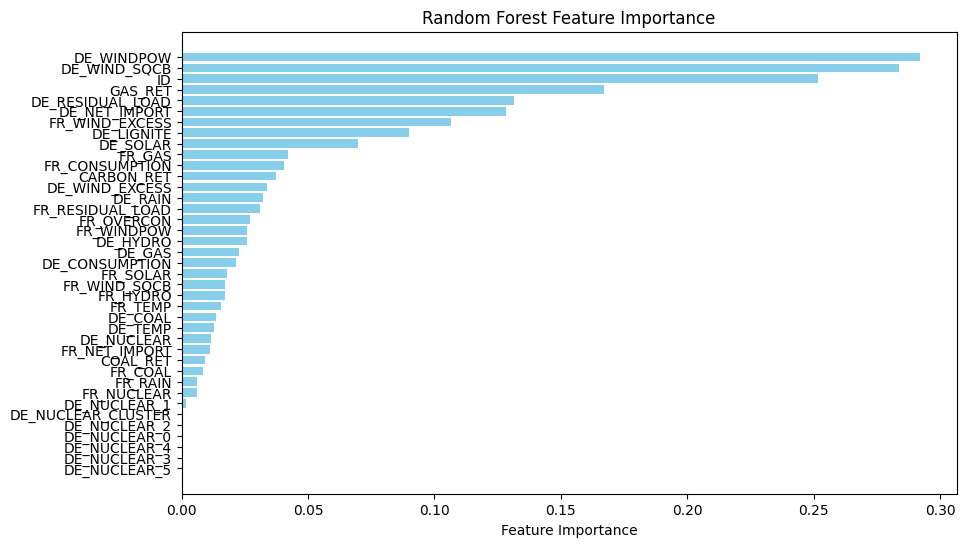

In [28]:
# Sort features by importance in descending order
sorted_importance = sorted(permutation_importance_dict.items(), key=lambda x: x[1], reverse=False)

# Extract sorted feature names and importance scores
sorted_features, sorted_importances = zip(*sorted_importance)

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()